### 分析calibration方法直接操作概率值是否会造成分布的破坏

In [90]:
# step1 计算置信度和准确率
import torch
import numpy as np
rep_debias_path = "/mnt/code/users/xuziyang/PromptBias/outputs/openprompt/manual_prompt/filter_out_0_biased_tokens/bert-base-cased/LAMA/debias_answer_type_tokens/origin_embedding/preds.pt"
calibrate_path = "/mnt/code/users/xuziyang/PromptBias/outputs/openprompt/manual_prompt/filter_out_0_biased_tokens/bert-base-cased/LAMA/calibrate_answer_type_tokens/origin_embedding/preds.pt"

rep_debias_data = torch.load(rep_debias_path)
calibrate_data = torch.load(calibrate_path)

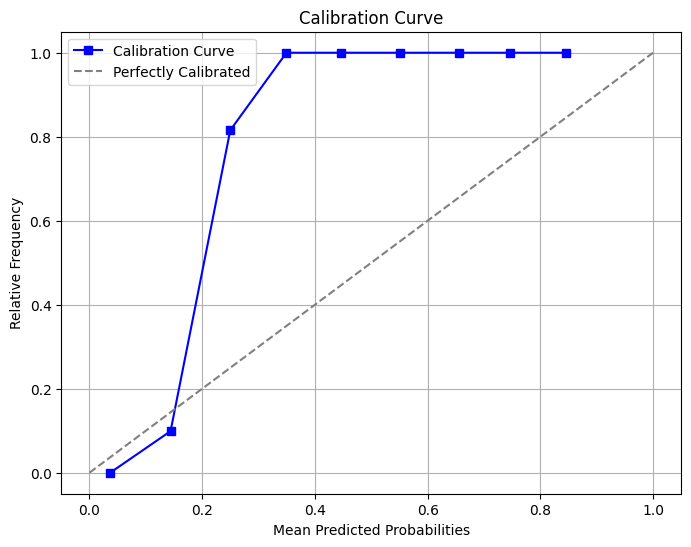

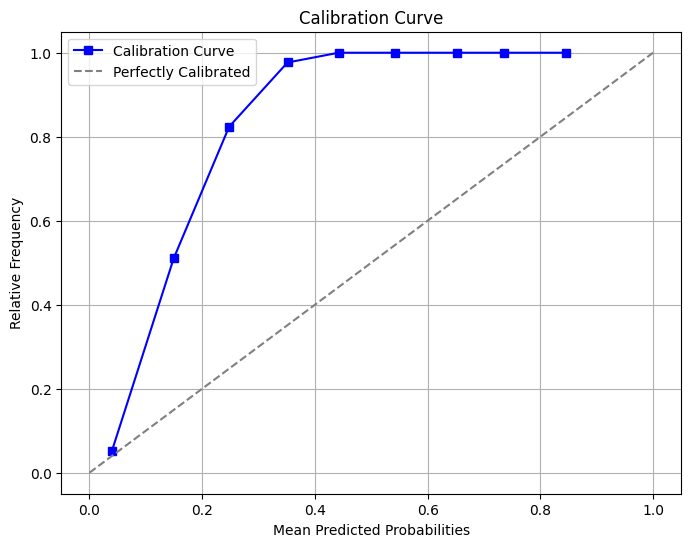

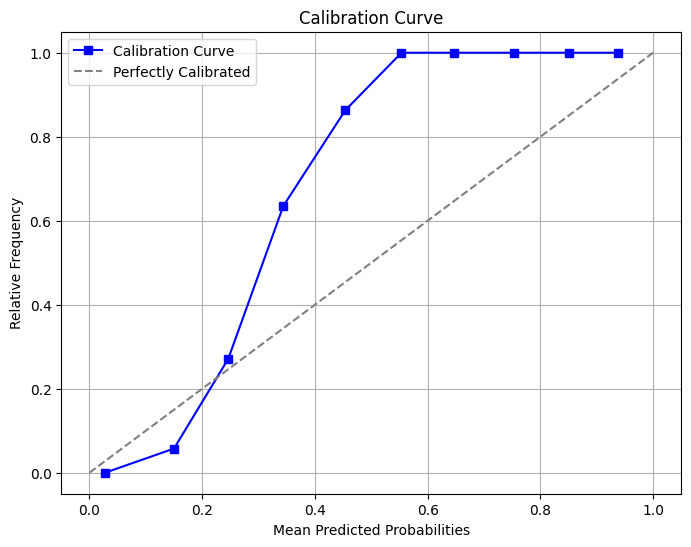

In [107]:
from matplotlib import pyplot as plt
import torch
from sklearn.calibration import calibration_curve
def reliab_curve(probs, labels, bin_num=10,):
    """绘制可靠性图"""
    num = len(probs)
    preds = torch.argmax(probs, dim=1).cpu().numpy()
    labels_np = labels.cpu().numpy()
    corretness = (preds==labels_np).astype(int)
    label_probs = torch.gather(probs, 1, labels.unsqueeze(1).cpu()).squeeze(1).numpy()
    
    probs_true, probs_pred = calibration_curve(corretness, label_probs, n_bins=bin_num)

    fig,axs = plt.subplots(1,1,figsize=(8,6))
    axs.plot(probs_pred, probs_true, marker="s", linestyle='-',color='b', label='Calibration Curve')

    # 辅助线
    axs.plot([0,1], [0,1], linestyle='--', color='gray', label="Perfectly Calibrated")
    axs.set_xlabel("Mean Predicted Probabilities")
    axs.set_ylabel("Relative Frequency")
    axs.set_title("Calibration Curve")
    axs.legend()
    axs.grid(True)
    # axs.show()


def reliab_curve_average(data,bin_num=10, draw_raw_probs=False):
    all_probs_true = []
    all_probs_pred = []
    for rel in data.keys():
        if draw_raw_probs:
            probs = data[rel]["data"]["raw_probs"]
        else:
            probs = data[rel]["data"]["debiased_probs"]
        labels = data[rel]["data"]["label_subvocab_ids"]

        preds = torch.argmax(probs, dim=1).cpu().numpy()
        labels_np = labels.cpu().numpy()
        corretness = (preds==labels_np).astype(int)
        label_probs = torch.gather(probs, 1, labels.unsqueeze(1).cpu()).squeeze(1).numpy()
        
        probs_true, probs_pred = calibration_curve(corretness, label_probs, n_bins=bin_num)
        all_probs_true.append(probs_true)
        all_probs_pred.append(probs_pred)
        
    
    # print(all_probs_true)
    # print(all_probs_pred)
    
    count_num = [0]*bin_num
    sum_prob_true = [0]*bin_num
    sum_prob_pred = [0]*bin_num
    for i in range(bin_num):
        for prob_true, prob_pred in zip(all_probs_true, all_probs_pred):
            # print(prob_true)
            try:
                sum_prob_true[i]+=prob_true[i]
                sum_prob_pred[i]+=prob_pred[i]
                count_num[i] += 1
            except:
                pass
    
    # print(count_num)
    if count_num[-1] == 0:
        sum_prob_true = sum_prob_true[:-1]
        sum_prob_pred = sum_prob_pred[:-1]
        count_num = count_num[-1]
    

    avg_probs_true = np.array(sum_prob_true)/np.array(count_num)
    avg_probs_pred = np.array(sum_prob_pred)/np.array(count_num)

    print(avg_probs_true)
    print(avg_probs_pred)

    fig,axs = plt.subplots(1,1,figsize=(8,6))
    axs.plot(avg_probs_pred, avg_probs_true, marker="s", linestyle='-',color='b', label='Calibration Curve')

    # 辅助线
    axs.plot([0,1], [0,1], linestyle='--', color='gray', label="Perfectly Calibrated")
    axs.set_xlabel("Mean Predicted Probabilities")
    axs.set_ylabel("Relative Frequency")
    axs.set_title("Mean Calibration Curve")
    axs.legend()
    axs.grid(True)




relation = "P1412"

cal_probs = calibrate_data["WIKI-UNI"][relation]["data"]["debiased_probs"]
raw_probs = calibrate_data["WIKI-UNI"][relation]["data"]["raw_probs"]
rep_probs = rep_debias_data["WIKI-UNI"][relation]["data"]["debiased_probs"]
labels = rep_debias_data["WIKI-UNI"][relation]["data"]["label_subvocab_ids"]


reliab_curve(raw_probs,labels)
reliab_curve(cal_probs,labels)
reliab_curve(rep_probs,labels)

# reliab_curve_average(calibrate_data["WIKI-UNI"], draw_raw_probs=True)
# reliab_curve_average(calibrate_data["WIKI-UNI"])
# reliab_curve_average(rep_debias_data["WIKI-UNI"])



In [104]:
calibrate_data["WIKI-UNI"]==rep_debias_data["WIKI-UNI"]

False

In [101]:
torch.sum(rep_debias_data["WIKI-UNI"]["P1001"]["data"]["debiased_probs"][0])
# torch.sum(calibrate_data["WIKI-UNI"]["P1001"]["data"]["debiased_probs"][0])

tensor(1., dtype=torch.float16)

In [54]:
cal_probs = calibrate_P1412["debiased_probs"]
labels = rep_debias_P1412["label_subvocab_ids"]

In [18]:
rep_debias_P1412.keys()

dict_keys(['index', 'sub_label', 'obj_labels', 'raw_preds', 'debiased_preds', 'raw_probs', 'debiased_probs', 'label_subvocab_ids', 'label_ids'])

In [ ]:
from sklearn.metrics import brier_score_loss
import numpy as np
cal_probs = calibrate_P1412["debiased_probs"].cpu().numpy()
raw_probs = calibrate_P1412["raw_probs"].cpu().numpy()
rep_probs = rep_debias_P1412["debiased_probs"].cpu().numpy()
labels = rep_debias_P1412["label_subvocab_ids"].cpu().numpy()

cal_brier_score = brier_score_loss(labels, cal_probs)
print(cal_brier_score)
